In [134]:
import pandas as pd
from database import select_dataset
import numpy as np

In [135]:
aquastat = select_dataset('aquastat').dropna()
evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
grossaddedvalues = select_dataset('grossaddedvalue')#.drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')

In [136]:
def pivot(df):
    return df.pivot(index=['ISO', 'Year'], columns='Variable', values='Value')

def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


In [30]:
def process_datasets(aquastat, efficientwater, grossaddedvalues,  evapotranspiration, cropcalendar):
    '''To cleanup !!! '''
    
    aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
    aquastat = aquastat[aquastat.Variable != 'CI']
    aquastat['Year'] = aquastat['Year'].astype(int)
    grossaddedvalues['Year'] = grossaddedvalues['Year'].astype(int)
    
    aquastat = fill_missing_values(pivot(aquastat))
    evapotranspiration = pivot(evapotranspiration)
    ETa = fill_missing_values(evapotranspiration['ETa'])
    ETo = evapotranspiration['ETo'].reset_index('Year', drop=True).dropna()
    cropcalendar = cropcalendar.pivot(index=['ISO', 'Item'], columns='Variable', values='Value')
    grossaddedvalues = pivot(grossaddedvalues)
    efficientwater = pivot(efficientwater)

    X = df_to_dict(aquastat)
    
    gva = df_to_dict(grossaddedvalues)
    ew = df_to_dict(efficientwater)
    
    X.update(gva)
    X.update(ew)
    
    X['ETa'] = ETa
    X['ETo'] = ETo
    X['LWU'] = 0
    X['KC'] = cropcalendar['Kc']
    X['ICA'] = cropcalendar['ICA']
    
    return X

In [31]:
data_dict = process_datasets(aquastat, efficientwater, grossaddedvalues,  evapotranspiration, cropcalendar)

# Model

In [22]:
from graphmodels.graphmodel_exp import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np

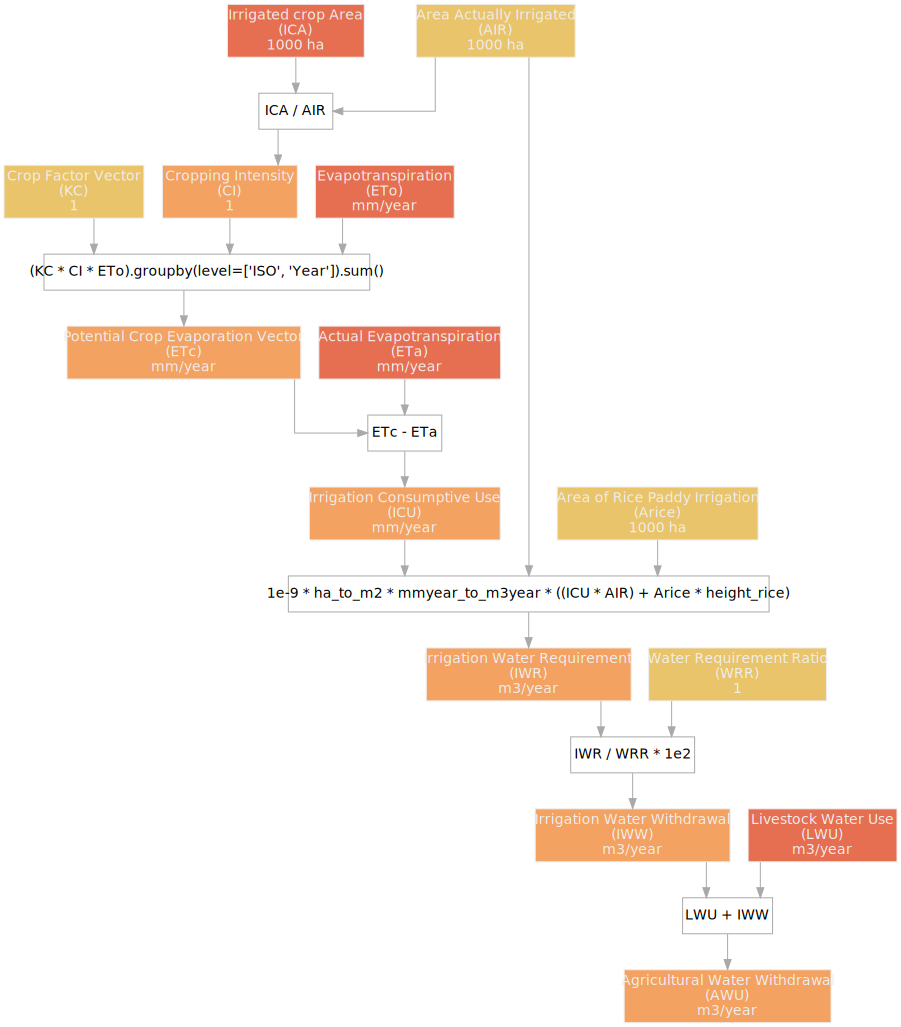

In [32]:
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e3 #* 1e3
mm_to_m = 1 # 1e-3 TO CHECK
mmyear_to_m3year = 10 # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'KC': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor Vector'},
             'ICA': {'type': 'input', 'unit':'1000 ha', 'name': 'Irrigated crop Area'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                   },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda KC, CI, ETo, **kwargs: (KC * CI * ETo).groupby(level=['ISO', 'Year']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: ETc - ETa
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
#              'PSIR': {'type': 'input',
#                       'unit': '1',
#                       'name': 'Proportion of Surface Irrigation'},
#              'PSPIR': {'type': 'input',
#                        'unit': '1',
#                        'name': 'Proportion of Sprinker Irrigation'},
#              'PLIR': {'type': 'input',
#                       'unit': '1',
#                       'name': 'Proportion of Localised Irrigation'},
#              'ESIR': {'type': 'parameter',
#                       'unit': '1',
#                       'name': 'Efficiency of Surface Irrigation'},
#              'ESPIR': {'type': 'parameter',
#                        'unit': '1',
#                        'name': 'Efficiency of Sprinker Irrigation'},
#              'ELIR': {'type': 'parameter',
#                       'unit': '1',
#                       'name': 'Efficiency of Localised Irrigation'},
#              'WRR_policy': {'type': 'variable',
#                             'name': 'Water Requirement Ratio',
#                             'unit': '1',
#                             'computation': lambda PSIR, ESIR, PSPIR, ESPIR, PLIR, ELIR, **kwargs: PSIR/ESIR + PSPIR / ESPIR + PLIR / ELIR
#                             },
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': 'm3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'LWU': {'type': 'input', 'name': 'Livestock Water Use', 'unit': 'm3/year'},
             'AWU': {'type': 'variable', 'unit': 'm3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda LWU, IWW, **kwargs: LWU + IWW
                     },
             }

IWW_model = GraphModel(IWW_nodes)

IWW_model.draw()

In [81]:
from sklearn.metrics import r2_score
import plotly.express as px

def check_model(Model, X, y_true):
    '''Run a model without scenario to check that the aggregation is correct
    
    TO CLEAN UP
    
    '''
    
    results = Model.run(X)
    
    print('Checking computations:')
    for key in y_true.keys():
        computation = results[key]
        baseline = y_true[key]
        scores = scores_baseline_computation(baseline, computation)
        print(key, "r2:", scores['r2'], end=' | ')
        print(key, "corr:", scores['corr'])
    

def scores_baseline_computation(baseline, computation):
    base_comp = pd.concat([baseline, computation], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    base_comp.columns=['baseline', 'computation']
    
    return {'r2': r2_score(base_comp.baseline, base_comp.computation), 'corr':base_comp.baseline.corr(base_comp.computation)}

In [99]:
def plot_computation_vs_baseline(computation, baseline):
    df = pd.concat([computation, baseline],axis=1).dropna()
    df.columns = ['computation','baseline']
    fig = px.scatter(df.reset_index(), x=f'baseline', y=f'computation', hover_data=['ISO', 'Year'])
    return fig

def check_variable_graph(Model, X, y_true, var):
    """TO CLEAN UP"""
    results = Model.run(X)

    computation = results[var]
    baseline = y_true[var]
    scores = scores_baseline_computation(baseline, computation)
    print(var, "r2:", scores['r2'], end=' | ')
    print(var, "corr:", scores['corr'])
    
    return plot_computation_vs_baseline(baseline, computation)

In [100]:
X = {key: data_dict[key] for key in IWW_model.inputs_() + IWW_model.parameters_()}
y_true = {key: data_dict[key] for key in IWW_model.variables_() + IWW_model.outputs_() if key in data_dict}
check_model(IWW_model, X, y_true)

Checking computations:
IWR r2: -358.285722054339 | IWR corr: 0.9379986749670276
IWW r2: -640.5272229145364 | IWW corr: 0.4184869553410475
AWU r2: -340.05913382899 | AWU corr: 0.9135028659380575


In [102]:
check_variable_graph(IWW_model, X, y_true, var='AWU')

AWU r2: -340.05913382899 | AWU corr: 0.9135028659380575


In [104]:
# import plotly.express as px

# test= pd.concat([X['IWR'] * 1e9, res['IWR'].replace(0, np.nan)], axis=1)
# test.columns = ['IWR', 'IWR_comp']

# px.scatter(test.reset_index(), x='IWR', y='IWR_comp',
#            hover_data=['ISO', 'Year'], trendline='ols')
# import plotly.express as px

# test= pd.concat([X['IWR'] * 1e9, X['AIR'].replace(0, np.nan)], axis=1)
# test.columns = ['IWR', 'AIR']

# px.scatter(test.reset_index(), x='IWR', y='AIR',
#            hover_data=['ISO', 'Year'], trendline='ols')

# MWU

In [181]:
wb_data = select_dataset('worldbank')#.set_index(['ISO', 'Year'])
aqua_df = select_dataset('aquastat')#.set_index(['ISO', 'Year'])

In [198]:
gdp_pop = wb_data[wb_data.Variable.isin(['GDP', 'Pop'])]
gdp_pop['Year'] = gdp_pop['Year'].astype(int)
gdp_pop = gdp_pop[gdp_pop.Year == 2005]
mwu_wp = aqua_df[aqua_df.Variable.isin(['WP', 'MWU'])]
mwu_wp['Year'] = mwu_wp['Year'].astype(int)
#mwu_wp = mwu_wp[mwu_wp.Year == 2005]

/home/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [225]:
mwu = mwu_wp.query("Variable == 'MWU' and Year == 2005")[['ISO', 'Value']]

In [226]:
wp  = mwu_wp.query("Variable == 'WP'")[['ISO', 'Value']]

In [227]:
gdp = gdp_pop.query("Variable == 'GDP' and Year == 2005")[['ISO', 'Value']]

In [228]:
pop = gdp_pop.query("Variable == 'Pop' and Year == 2005")[['ISO', 'Value']]

In [310]:
import numpy as np

dfs = [df.set_index('ISO') for df in [mwu, wp, gdp, pop]]
df = pd.concat(dfs, axis=1).dropna()
df.columns = ['MWU', 'WP', 'GDP', 'POP']

df['GDPc'] = df['GDP'] / df['POP']
df['log_MWU'] = np.log(df['MWU'])
df['log_WP'] = np.log(df['WP'])
df['log_GDP'] = np.log(df['GDP'])
df['log_POP'] = np.log(df['POP'])
df['log_GDPc'] =  np.log(df['GDPc'])

In [328]:
import plotly.express as px
from matplotlib import pyplot as plt

In [338]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula='log_MWU ~  log_WP + log_GDPc + log_POP', data=df)
res = mod.fit()

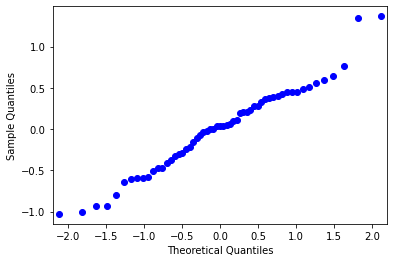

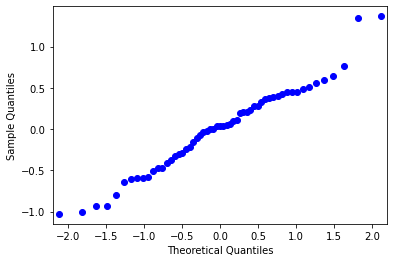

In [339]:
 sm.qqplot( mod.fit().resid)

In [340]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_MWU   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     201.8
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           5.72e-29
Time:                        15:56:30   Log-Likelihood:                -43.622
No. Observations:                  57   AIC:                             95.24
Df Residuals:                      53   BIC:                             103.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.9831      0.872    -25.213      0.000     -23.732     -20.234
log_WP        -0.2099      0.094     -2.230      0.030      -0.399      -0.021
log_GDPc       0.6379      0.056     11.378      0.000       0.525       0.750
log_POP        1.6301      0.075     21.786      0.000       1.480       1.780
==============================================================================
Omnibus:                        0.549   Durbin-Watson:                   2.427
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.214
Skew:                           0.142   Prob(JB):                        0.899
Kurtosis:                       3.097   Cond. No.                         220.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [326]:
df['MWU_comp'] = np.exp(-21.9831 + - 0.2099 * df.log_WP + 0.6379 * df.log_GDPc + 1.6301* df.log_POP)

In [327]:
px.scatter(df, x='MWU', y='MWU_comp', trendline='ols')

In [322]:
mod = smf.ols(formula='MWU ~  WP + GDPc + POP', data=df)
res = mod.fit()

In [323]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MWU   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     45.23
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           1.22e-14
Time:                        15:47:13   Log-Likelihood:                -168.71
No. Observations:                  57   AIC:                             345.4
Df Residuals:                      53   BIC:                             353.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8264      1.037     -3.691      0.001      -5.906      -1.747
WP             3.9557      1.137      3.478      0.001       1.674       6.237
GDPc         -25.5836     25.816     -0.991      0.326     -77.363      26.196
POP          1.29e-07   1.19e-08     10.867      0.000    1.05e-07    1.53e-07
==============================================================================
Omnibus:                       38.622   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.109
Skew:                           1.467   Prob(JB):                     6.04e-59
Kurtosis:                      13.212   Cond. No.                     2.46e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [314]:
px.scatter(df, x='log_POP', y='log_MWU', trendline='ols')

In [317]:
px.scatter(df, x='log_GDPc', y='log_MWU', trendline='ols')

In [289]:
px.scatter(df, x='GDP', y='WP', trendline='ols')

In [275]:
px.scatter(df, x='log_WP', y='log_MWU', trendline='ols')

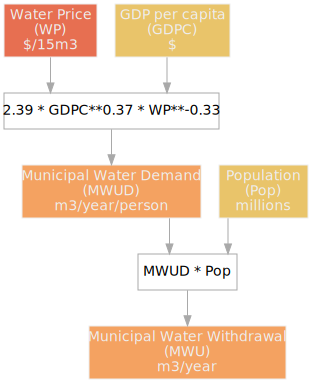

In [144]:
MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'MWUD': {'type': 'variable',
                      'name': 'Municipal Water Demand',
                      'unit': 'm3/year/person',
                      'computation': lambda GDPC, WP, **kwargs: 2.39 * GDPC**0.37 * WP**-0.33
                      },
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'millions'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda MWUD, Pop, **kwargs: MWUD * Pop
                     }
             }
MWU_model = GraphModel(MWU_nodes)
MWU_model.draw()


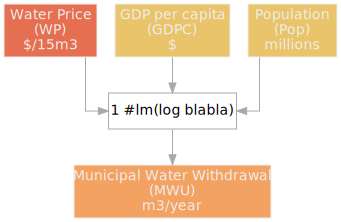

In [337]:
MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'millions'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: 1 #lm(log blabla)
                     }
             }
MWU_model = GraphModel(MWU_nodes)
MWU_model.draw()


In [145]:
data_dict['MWU']

{'AIR': ISO  Year
 AFG  1990    2660.0
      1992    2660.0
      1997    2660.0
      1998    2660.0
      2000    2660.0
               ...  
 ZWE  2002     123.9
      2007     123.9
      2012     123.9
      2016     123.9
      2017     123.9
 Name: AIR, Length: 2211, dtype: float64,
 'AWU': ISO  Year
 AFG  1990    20.000
      1992    20.000
      1997    20.000
      1998    20.000
      2000    20.000
               ...  
 ZWE  2002     3.318
      2007     2.930
      2012     2.930
      2016     2.930
      2017     2.770
 Name: AWU, Length: 2211, dtype: float64,
 'Arice': ISO  Year
 AFG  1990    208.0
      1992    208.0
      1997    208.0
      1998    208.0
      2000    208.0
              ...  
 ZWE  2002      0.0
      2007      0.0
      2012      0.0
      2016      0.0
      2017      0.0
 Name: Arice, Length: 2211, dtype: float64,
 'DW': ISO  Year
 AFG  1990    0.0
      1992    0.0
      1997    0.0
      1998    0.0
      2000    0.0
             ... 
 ZWE  200

# EW1

In [113]:
EW1_nodes = {'IWU': {'type': 'input',
                     'name': 'Industrial Water Withdrawal',
                     'unit': 'm3/year'},
#              'AIR': {'type': 'parameter',
#                      'unit': '1000 ha',
#                      'name': 'Area Actually Irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': 'm3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
#              'TC': {'type': 'parameter',
#                     'unit': '1000 ha',
#                     'name': 'Total Cultivated Land'},
#              'Ai': {'type': 'variable',
#                     'name': 'Proportion of Irrigated Land',
#                     'unit': '',
#                     'computation': lambda AIR, TC, **kwargs: AIR / TC
#                     },
#              'Cr': {'type': 'variable',
#                     'name': 'Corrective coefficient',
#                     'unit': '',
#                     'computation': lambda Ai, **kwargs: 1 / (1 + (Ai/(1-Ai)*0.375))
#                     },
             'AGVA': {'type': 'parameter',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$'},

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},
 
             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
  
     
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, IGVA, SGVA, AGVA, **kwargs: 1e-9 * (IGVA + SGVA + AGVA) / TWW
                     }}

EW1_model = GraphModel(EW1_nodes)

In [114]:
X = {key: data_dict[key] for key in EW1_model.inputs_() + EW1_model.parameters_()}
y_true = {key: data_dict[key] for key in EW1_model.variables_() + EW1_model.outputs_() if key in data_dict}
check_model(EW1_model, X, y_true)

Checking computations:
TWW r2: 0.9898726061160114 | TWW corr: 0.9949329706458682
EW1 r2: -1.2609480228297194 | EW1 corr: 0.495907615124717


In [115]:
check_variable_graph(EW1_model, X, y_true, var='EW1')

EW1 r2: -1.2609480228297194 | EW1 corr: 0.495907615124717


In [112]:
ha_to_m2 = 1e4 
mm_to_m = 1e-3

EW2_nodes = {
#              'P': {'type': 'input', 'unit': 'mm/year', 'name': 'Precipitation'},
#              'ETa': {'type': 'input', 'unit': 'mm/year', 'name': 'Actual Evapotranspiration'},
#              'A': {'type': 'input', 'unit': 'ha', 'name': 'Catchment Size'},
#              'S': {'type': 'variable',
#                    'name': 'Change in Surface Water Storage',
#                    'unit': 'm3/year',
#                    'computation': lambda P, ETa, A, **kwargs: (P - ETa) * A * ha_m2 * mm_to_m
#                   },
#              'SW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Surface Water'},
#              'GW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Groundwater Water'},
#              'Overlap': {'type': 'parameter',
#                          'unit': 'm3/year',
#                          'name': 'Overlap (Surface - Groundwater)'},
             'IRWR': {'type': 'input',
                      'name': 'Internal Renewable Water Resources',
                      'unit': 'm3/year',
                      #'computation': lambda GW, SW, S, Overlap, **kwargs: GW + (SW - S) - Overlap
                     },
             'ERWR': {'type': 'input',
                      'unit': 'm3/year',
                      'name': 'External Renewable Water Resources'},
             'TRF': {'type': 'variable',
                     'name': 'Total Renewable Freshwater',
                     'unit': 'm3/year',
                     'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
                    },
             'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
             'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
             'TNCW': {'type': 'variable',
                      'name': 'Total Non Conventional Water',
                      'unit': 'm3/year',
                      'computation': lambda DW, TW, **kwargs: DW + TW
                     },
             'TFA': {'type': 'variable',
                     'name': 'Total Freshwater Available',
                     'unit': 'm3/year',
                     'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
                    },
             'TWW': {'type': 'input', 'unit': 'm3/year', 'name': 'Total Water Withdrawal'},
             'EFR': {'type': 'parameter',
                     'unit': 'm3/year',
                     'name': 'Environmental Flow Requirement'},
             'EW2': {'type': 'output',
                     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                     'unit': '1',
                     'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR)
                    },
             'Natural EW2': {'type': 'output',
                             'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                             'unit': '1',
                             'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR)
                            }
            }

EW2_model = GraphModel(EW2_nodes)

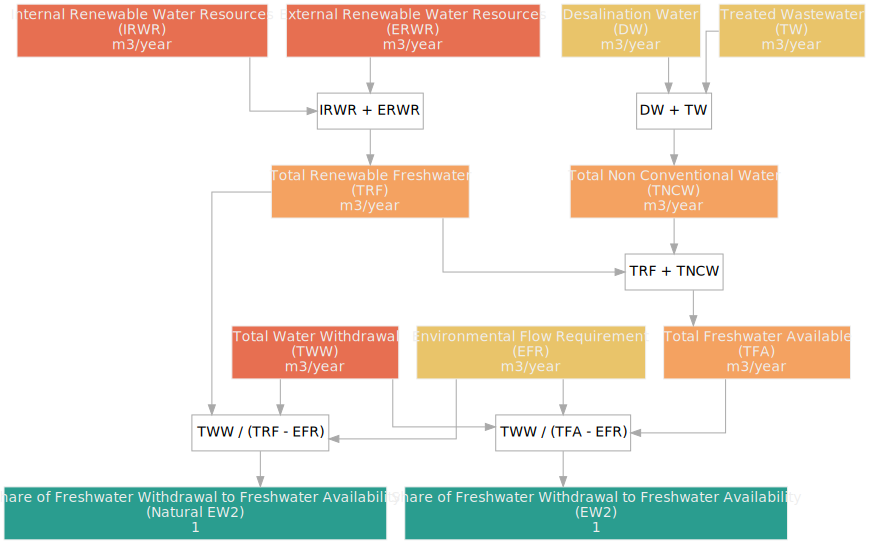

In [77]:
EW2_model.draw()

In [117]:
X = {key: data_dict[key] for key in EW2_model.inputs_() + EW2_model.parameters_()}
y_true = {key: data_dict[key] for key in EW2_model.variables_() + EW2_model.outputs_() if key in data_dict}
check_model(EW2_model, X, y_true)

Checking computations:
TFA r2: 0.9751366093461206 | TFA corr: 0.9901343095123072
EW2 r2: -0.07608630057934063 | EW2 corr: 0.25867251488371035


In [118]:
check_variable_graph(EW2_model, X, y_true, var='EW2')

EW2 r2: -0.07608630057934063 | EW2 corr: 0.25867251488371035


# cleanup

In [ ]:
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e3 #* 1e3
mm_to_m = 1 # 1e-3

IWW_nodes = {'KC': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor Vector'},
             'CI': {'type': 'parameter', 'unit': '%', 'name': 'Cropping Intensity'},
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda KC, CI, ETo, **kwargs: KC * ETo
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: ETc - ETa
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'PSIR': {'type': 'input',
                      'unit': '1',
                      'name': 'Proportion of Surface Irrigation'},
             'PSPIR': {'type': 'input',
                       'unit': '1',
                       'name': 'Proportion of Sprinker Irrigation'},
             'PLIR': {'type': 'input',
                      'unit': '1',
                      'name': 'Proportion of Localised Irrigation'},
             'ESIR': {'type': 'parameter',
                      'unit': '1',
                      'name': 'Efficiency of Surface Irrigation'},
             'ESPIR': {'type': 'parameter',
                       'unit': '1',
                       'name': 'Efficiency of Sprinker Irrigation'},
             'ELIR': {'type': 'parameter',
                      'unit': '1',
                      'name': 'Efficiency of Localised Irrigation'},
             'WRR_policy': {'type': 'variable',
                            'name': 'Water Requirement Ratio',
                            'unit': '1',
                            'computation': lambda PSIR, ESIR, PSPIR, ESPIR, PLIR, ELIR, **kwargs: PSIR/ESIR + PSPIR / ESPIR + PLIR / ELIR
                            },
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': 'm3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: ha_to_m2 * ((mm_to_m * ICU * AIR).groupby(level='ISO').sum() + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'LWU': {'type': 'input', 'name': 'Livestock Water Use', 'unit': 'm3/year'},
             'AWU': {'type': 'variable', 'unit': 'm3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda LWU, IWW, **kwargs: LWU + IWW
                     },
             }

IWW_model = GraphModel(IWW_nodes)

IWW_model.draw()

In [ ]:
EW1_nodes = {'IWU': {'type': 'input',
                     'name': 'Industrial Water Withdrawal',
                     'unit': 'm3/year'},
#              'AIR': {'type': 'parameter',
#                      'unit': '1000 ha',
#                      'name': 'Area Actually Irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': 'm3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
#              'TC': {'type': 'parameter',
#                     'unit': '1000 ha',
#                     'name': 'Total Cultivated Land'},
#              'Ai': {'type': 'variable',
#                     'name': 'Proportion of Irrigated Land',
#                     'unit': '',
#                     'computation': lambda AIR, TC, **kwargs: AIR / TC
#                     },
#              'Cr': {'type': 'variable',
#                     'name': 'Corrective coefficient',
#                     'unit': '',
#                     'computation': lambda Ai, **kwargs: 1 / (1 + (Ai/(1-Ai)*0.375))
#                     },
             'AGVA': {'type': 'parameter',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$'},

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},
 
             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
  
     
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, IGVA, SGVA, AGVA, **kwargs: (IGVA + SGVA + AGVA) / TWW
                     }}
EW1_model = GraphModel(EW1_nodes)

EW1_model.draw()


In [ ]:
res = EW1_model.run(X)

In [ ]:
ha_to_m2 = 1e4 
mm_to_m = 1e-3

EW2_nodes = {'P': {'type': 'input', 'unit': 'mm/year', 'name': 'Precipitation'},
             'ETa': {'type': 'input', 'unit': 'mm/year', 'name': 'Actual Evapotranspiration'},
             'A': {'type': 'input', 'unit': 'ha', 'name': 'Catchment Size'},
             'S': {'type': 'variable',
                   'name': 'Change in Surface Water Storage',
                   'unit': 'm3/year',
                   'computation': lambda P, ETa, A, **kwargs: (P - ETa) * A * ha_m2 * mm_to_m
                  },
             'SW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Surface Water'},
             'GW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Groundwater Water'},
             'Overlap': {'type': 'parameter',
                         'unit': 'm3/year',
                         'name': 'Overlap (Surface - Groundwater)'},
             'IRWR': {'type': 'variable',
                      'name': 'Internal Renewable Water Resources',
                      'unit': 'm3/year',
                      'computation': lambda GW, SW, S, Overlap, **kwargs: GW + (SW - S) - Overlap
                     },
             'ERWR': {'type': 'parameter',
                      'unit': 'm3/year',
                      'name': 'External Renewable Water Resources'},
             'TRF': {'type': 'variable',
                     'name': 'Total Renewable Freshwater',
                     'unit': 'm3/year',
                     'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
                    },
             'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
             'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
             'TNCW': {'type': 'variable',
                      'name': 'Total Non Conventional Water',
                      'unit': 'm3/year',
                      'computation': lambda DW, TW, **kwargs: DW + TW
                     },
             'TFA': {'type': 'variable',
                     'name': 'Total Freshwater Available',
                     'unit': 'm3/year',
                     'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
                    },
             'TWW': {'type': 'input', 'unit': 'm3/year', 'name': 'Total Water Withdrawal'},
             'EFR': {'type': 'parameter',
                     'unit': 'm3/year',
                     'name': 'Environmental Flow Requirement'},
             'EW2': {'type': 'output',
                     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                     'unit': '1',
                     'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR)
                    },
             'Natural EW2': {'type': 'output',
                             'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                             'unit': '1',
                             'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR)
                            }
            }

GraphModel(EW2_nodes).draw()


In [ ]:
#Municipal Water Use
MWU_nodes= [{'type': 'input',
  'name': 'Water Price', 
  'unit': '$/15m3',
  'id': 'P'},
  {'type': 'parameter',
  'name': 'GDP per capita',
  'unit': '$',
  'id': 'GDPC'}, 
  {'type': 'variable',
  'name': 'Municipal Water Demand',
  'unit': 'm3/year/person',
  'in': ['P','GDPC'],
  'computation': {'name': '2.39 * GDPC^0.37 * Price^-0.33 ', 'formula': lambda X: 2.39 * X['GDPC']**0.37 * X['P']**-0.33},
  'id': 'MWUD'},
  {'type': 'parameter',
  'name': 'Population',
  'unit': 'millions',
  'id': 'Pop'}, 
  {'type': 'variable',
  'name': 'Municipal Water Withdrawal',
  'unit': 'm3/year',
  'in': ['Pop','MWUD'],
  'computation': {'name': 'MWUD * Pop ', 'formula': lambda X: X['MWUD'] * X['Pop']},
  'id': 'MWU'},
    ]

GraphModel(MWU_nodes).draw()


In [ ]:
EW1_nodes =[ 
 #Industrial Water Use
{'type': 'parameter',  
  'name': 'Industrial Water Withdrawal',
  'unit': 'm3/year',
  'id': 'IWU'},
  {'type': 'parameter',
  'unit': 'ha (1000)',
  'name': 'Area Actually Irrigated',
  'id': 'AIR'},
  {'type': 'input',
  'name': 'Municipal Water Withdrawal',
  'unit': 'm3/year',
  'id': 'MWU'},    
{'type': 'input',
  'name': 'Agricultural Water Withdrawal',
  'unit': 'm3/year',
  'id': 'AWU'},

#Total Water Withdrawal
 {'type': 'variable',
  'name': 'Total Water Withdrawal',
  'unit': 'm3/year',
  'in': ['MWU','AWU', 'IWU'],
  'computation': {'name': 'AWU + IWU + MWU', 'formula': lambda X: X['AWU'] + X['IWU'] + X['MWU']},
  'id': 'TWW'},

 #Agricultural Water Use Efficiency
 {'type': 'parameter',
  'unit': 'ha (1000)',
  'name': 'Total Cultivated Land',
  'id': 'TC'},
 {'type': 'variable',
  'name': 'Proportion of Irrigated Land',
  'unit': '',
  'in': ['AIR', 'TC'],
  'computation': {'name': 'AIR/TC', 'formula': lambda X: X['AIR'] / X['TC']},
  'id': 'Ai'},
{'type': 'variable',
  'name': 'Corrective coefficient',
  'unit': '',
  'in': ['Ai'],
  'computation': {'name': '1/(1+(Ai/(1-Ai)*0.375)', 'formula': lambda X: 1/(1 + (X['Ai']/(1-X['Ai'])*0.375))},
  'id': 'Cr'},
{'type': 'parameter',
  'name': 'Agricultural Gross Value Added',
  'unit': '$',
  'id': 'AGVA'},
{'type': 'variable',
  'name': 'Agricultural Water Use Efficiency',
  'unit': '$/m3',
  'in': ['AGVA', 'Cr', "AWU"],
  'computation': {'name': 'AGVA * (1-Cr)/AWU', 'formula': lambda X: X['AGVA'] * (1-X['Cr'])/X['AWU']},
  'id': 'WUEa'},  

#Industrial Water Use Efficiency
{'type': 'parameter',
  'name': 'Industrial Gross Value Added',
  'unit': '$',
  'id': 'IGVA'},

{'type': 'variable', #won't calculate this variable, have to define a value in X directory for model to run
  'name': 'Industrial Water Use Efficiency',
  'unit': '$/m3',
  'in': ['IGVA','IWU'],
  'computation': {'name': 'IGVA/IWU', 'formula': lambda X: X['IGVA']/ X['IWU']},
  'id': 'WUEi'},

#Municipal/Service sector water use efficiency
  {'type': 'parameter',
  'name': 'Service Sector Gross Value Added',
  'unit': '$',
  'id': 'SGVA'},
{'type': 'variable',
  'name': 'Service Sector Water Use Efficiency',
  'unit': '$/m3',
  'in': ['SGVA','MWU'],
  'computation': {'name': 'SGVA/MWU', 'formula': lambda X: X['SGVA']/ X['MWU']},
  'id': 'WUEs'},

#EW1 calculation
{'type': 'variable',
  'name': 'Proportion of Agricultural Water Use',
  'unit': '',
  'in': ['AWU','TWW'],
  'computation': {'name': 'AWU/TWW', 'formula': lambda X: X['AWU'] / X['TWW']},
  'id': 'Pa'},  

  {'type': 'variable', 
  'name': 'Proportion of Industrial Water Use',
  'unit': '',
  'in': ['IWU','TWW'],
  'computation': {'name': 'IWU/TWW', 'formula': lambda X: X['IWU'] / X['TWW']},
  'id': 'Pi'},  

  {'type': 'variable',
  'name': 'Proportion of Municipal Water Use',
  'unit': '%',
  'in': ['MWU','TWW'],
  'computation': {'name': 'MWU/TWW', 'formula': lambda X: X['MWU'] / X['TWW']},
  'id': 'Ps'},  
{'type': 'output',
  'name': 'Total Water Use Efficiency',
  'unit': '$/m3',
  'in': ['WUEa','Pa','WUEi','Pi', 'WUEs', 'Ps'],
  'computation': {'name': 'WUEa*Pa + WUEi*Pi + WUEs*Ps', 'formula': lambda X: X['WUEa'] * X['Pa'] + X['WUEi'] * X['Pi'] + X['WUEs'] * X['Ps']},
  'id': 'EW1'}

]
GraphModel(EW1_nodes).draw()

In [ ]:
EW2_nodes = [ 

#Renewable freshwater

#Climate scenario impacting the change in surface water, should be used for future climate predictions. Otherwise S = 0 in BAU scenario.
#Use of simplified water balance equation which only considers precipitation and evapotranspiration as main water fluxes.
#Potential to improve equation by incorporation of other process such as runoff, groundwater seepage and soil-water interactions if data and equations are available. 
{'type':'input', 
        'unit': 'mm/year',  
        'name': 'Precipitation', 
       'id': 'P'}, 
{'type':'input', 
        'unit': 'mm/year', 
        'name': 'Evapotranspiration', 
       'id': 'ET'}, 
{'type':'input', 
        'unit': 'ha', 
        'name': 'Catchment Size', 
       'id': 'A'}, 
 {'type': 'variable',
  'name': 'Change in Surface Water Storage',
  'unit': 'mm/year', #need to look into conversion of units think it would be m3/year
  'in': ['P', 'ET','A'],
  'computation': {'name': '(P - ET)*A', 'formula': lambda X: (X['P'] - X['ET']) * X['A']},
  'id': 'S'},

#Renewable Water Resources
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Surface Water', 
       'id': 'SW'}, 
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Groundwater Water', 
       'id': 'GW'}, 
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Overlap (Surface - Groundwater)', 
       'id': 'Overlap'}, 

 {'type': 'variable',
  'name': 'Internal Renewable Water Resources',
  'unit': 'm3/year',
  'in': ['SW', 'GW','Overlap', 'S'],
  'computation': {'name': 'GW + (SW + S) - Overlap', 'formula': lambda X: X['GW'] + (X['SW'] - X['S']) - X['Overlap']},
  'id': 'IRWR'},

{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'External Renewable Water Resources', 
       'id': 'ERWR'},       

 {'type': 'variable',
  'name': 'Total Renewable Freshwater',
  'unit': 'm3/year',
  'in': ['IRWR', 'ERWR'],
  'computation': {'name': 'IRWR + ERWR', 'formula': lambda X: X['IRWR'] + X['ERWR']},'id': 'TRF'},
  
  #Non conventional water 
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Desalination Water', 
       'id': 'DW'},  
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Treated Wastewater', 
       'id': 'TW'}, 
   {'type': 'variable',
  'name': 'Total Non Conventional Water',
  'unit': 'm3/year',
  'in': ['DW', 'TW'],
  'computation': {'name': 'DW + TW', 'formula': lambda X: X['DW'] + X['TW']},'id': 'TNCW'},
  {'type': 'variable',
  'name': 'Total Freshwater Available',
  'unit': 'm3/year',
  'in': ['TRF', 'TNCW'],
  'computation': {'name': 'TRF + TNCW', 'formula': lambda X: X['TRF'] + X['TNCW']},'id': 'TFA'},

#calculation of EW 2
#input from water use model
{'type':'input', 
        'unit': 'm3/year', 
        'name': 'Total Water Withdrawal', 
       'id': 'TWW'}, 
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Environmental Flow Requirement', 
       'id': 'EFR'}, 
       
#inclusion of both natural and non-conventional water sources
{'type': 'output',
  'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
  'unit': '%',
  'in': ['TFA', 'TWW', 'EFR'],
  'computation': {'name': 'TWW/(TFA-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TFA'] - X['EFR']) * 100},'id': 'EW2'},

#only natural water sources
{'type': 'output',
  'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
  'unit': '%',
  'in': ['TRF', 'TWW', 'EFR'],
  'computation': {'name': 'TWW/(TRF-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TRF'] - X['EFR']) * 100},'id': 'Natural EW2'},

  ]

GraphModel(EW2_nodes).draw()

In [ ]:
MWC_nodes =[
 {'type': 'input',
  'name': 'Municipal Water Withdrawal', #should be connecting to MWU variable from first water use model
  'unit': 'm3/year',
  'id': 'MWU'},

  {'type': 'input',
  'name': 'Water Supply Efficiency', #can also be a parameter if we want to keep constant
  'unit': '',
  'id': 'WSE'},

  {'type': 'output',
  'name': 'Municipal Water Consumption',
  'unit': 'm3/year',
  'in': ['MWU', 'WSE'],
  'id': 'MWC',
  'computation': {'name': 'MWU * WSE', 'formula': lambda X: X['MWU'] * X['WSE']}},
]

GraphModel(MWC_nodes).draw()

In [ ]:
#Wastewater treatment scenario
PIC_nodes = [{'type': 'input',
  'name': 'Vector of Number of Treatment Facilities',
  'unit': '',
  'id': 'Facilities'},
 {'type': 'parameter',
  'name': 'Wastewater Technology Treatment Capacity Vector',
  'unit': 'kilotons',
  'id': 'STC'},
{'type': 'parameter',
  'name': 'Sewage Efficiency Vector',
  'unit': '',
  'id': 'SE'},
{'type': 'variable',
  'name': 'Treated Wastewater Vector',
  'unit': 'kilotons',
  'in': ['Facilities', 'STC', 'SE'],
  'computation': {'name': 'Facilities * STC * Sewage Efficiency ', 'formula': lambda X: X['Facilities'] * X['STC'] * X['SE']},'id': 'STW'},

  #amount of investment required per technology
{'type': 'parameter',
  'name': 'Construction Cost Vector',
  'unit': '$', 
 'id': 'CAPEX'},
 
{'type': 'parameter',
  'name': 'Operational Cost Vector',
  'unit': '$/ton',
  'id': 'OPEX'},
 
 {'type': 'output',
  'name': 'Total Potential Investment Cost',
  'unit': '$',
  'in': ['CAPEX', 'OPEX', 'STW'],
  'computation': {'name': 'CAPEX + (OPEX*1000)*STW', 'formula': lambda X: sum(X['CAPEX'] + X['OPEX']*1000*X['STW'])},'id': 'PIC'},
  ]

GraphModel(PIC_nodes).draw()

In [ ]:

#Waste Generation Component
Waste_nodes = [{'type': 'parameter',
  'name': 'Total Physical Capital Stock',
  'unit': 'US$',
  'id': 'PCS'},

{'type': 'parameter',
  'name': 'Durable Consumption Good Stock',
  'unit': 'US$',
  'id': 'DCGS'},

{'type': 'parameter',
  'name': 'Rate of Capital Depreciation',
  'unit': '%',
  'id': 'RC'},

{'type': 'parameter',
  'name': 'Proportion of Durable Consumption Goods Discarded per year',
  'unit': '',
  'id': 'PDCG'},

{'type': 'variable',
  'name': 'Discarded Socio-Economic Stock',
  'unit': 'tonnes',
  'in': ['ME1','PCS', 'DCGS', 'RC', 'PDCG'],
  'computation': {'name': '(ME1 / 1000) * (RC*PCS + PDCG*DCGS)', 'formula': lambda X: (X['ME1'] / 1000)*(X['RC']*X['PCS'] + X['PDCG']*X['DCGS'])},'id': 'DSES'},

{'type': 'input',
  'name': 'Recycling Ratio',
  'unit': '',
  'id': 'RR'},
{'type': 'variable',
  'name': 'Recycled Socio-Economic Stock',
  'unit': 'tonnes',
  'in': ['DSES','RR'],
  'id': 'RSES',
  'computation': {'name': 'RR * DSES', 'formula': lambda X: X['DSES'] * X['RR']},},
{'type': 'output',
  'name': 'Total Waste Generated',
  'unit': 'tonnes',
  'in': ['DSES','RSES'],
  'id': 'Waste',
  'computation': {'name': 'DSES - RSES', 'formula': lambda X: X['DSES'] - X['RSES']}},
{'type': 'input',
  'name': 'Total DMC per GDP',
  'unit': 'tonnes/$',
  'id': 'ME1',},              
]
GraphModel(Waste_nodes).draw()

In [ ]:
VDMC = [{'type': 'input',
  'name': 'Vector of Total Domestic Extraction',
  'unit': 'tonnes',
 'id': 'DE'},

{'type': 'input',
  'name': 'Vector of Total Imports',
  'unit': 'tonnes',
  'id': 'I'},

{'type': 'input',
  'name': 'Vector of Total Exports',
  'unit': 'tonnes',
  'id': 'E'},
#Calculation of ME 1
{'type': 'variable',
  'name': 'Vector of DMC',
  'unit': 'tonnes',
  'in': ['DE','I','E'],
  'computation': {'name': '(DE + I) - E', 'formula': lambda X: (X['DE'] + X['I']) - X['E']},'id': 'VDMC'},
        
]

GraphModel(VDMC).draw()

In [ ]:
ME2_nodes = [  {'type': 'variable', #Hungary 
  'name': 'Total MF',
  'unit': 'tonnes',
 'id': 'MF'},
{'type': 'parameter',
  'name': 'Population',
  'unit': '',
  'id': 'Pop'},
{'type': 'output',
  'name': 'MF per capita',
  'unit': 'tonnes/per person',
  'in': ['Pop','MF'],
  'id': 'ME2',
  'computation': {'name': 'MF/Pop', 'formula': lambda X: X['MF'] / X['Pop']},}
]

GraphModel(ME2_nodes).draw()

In [ ]:
ME2_nodes = [
        {'type': 'variable',
      'name': 'Total DMC',
      'unit': 'tonnes',
        'id': 'DMC'},
{'type': 'parameter',
  'name': 'GDP',
  'unit': '$',
  'id': 'GDP'},

{'type': 'output',
  'name': 'Total DMC per GDP',
  'unit': 'tonnes/$',
  'in': ['DMC','GDP'],
  'id': 'ME1',
  'computation': {'name': 'DMC/GDP', 'formula': lambda X: X['DMC'] / X['GDP']*1000},},
]
GraphModel(ME2_nodes).draw()


In [ ]:
JE_nodes = [
    {'type': 'variable',
  'name': 'Vector of DMC',
  'unit': 'tonnes',
    'id': 'VDMC'},
    {'type': 'variable',
      'name': 'Total DMC',
      'unit': 'tonnes',
      'in': ['VDMC'],
      'computation': {'name': '(DE + I) - E', 'formula': lambda X: sum(X['VDMC'])},'id': 'DMC'},

#Calculation of ME 2
#Resource Efficiency Improvement Scenario
 {'type': 'input',
  'name': 'Material Efficiency Improvement',
  'unit': '%',
  'id': 'MI'},
{'type': 'variable',
  'name': 'Resources Saved',
  'unit': 'tonnes',
  'in': ['MI', 'DMC'],
  'id': 'RS',
  'computation': {'name': 'MI*DMC', 'formula': lambda X: X['MI'] * X['DMC 1'] ,}},

#Calculate share of each material in DMC
{'type': 'variable',
  'name': 'Share of Materials',
  'unit': '',
  'in': ['VDMC','DMC'],
  'computation': {'name': 'VDMC / DMC', 'formula': lambda X: X['VDMC'] / X['DMC']},'id': 'MS'},

{'type': 'parameter',
  'name': 'Vector of Lastest Average Prices of Commodities',
  'unit': '$',
  'id': 'AP'},

{'type': 'parameter',
  'name': 'Vector of Export Weights (to Total Commodities)',
  'unit': '',
  'id': 'EX'},

  {'type': 'variable',
  'name': 'Cost per unit of Materials',
  'unit': '$',
  'in': ['AP','EX'],
  'computation': {'name': 'AP * EX', 'formula': lambda X: X['AP'] * X['EX']},'id': 'CM'},

 {'type': 'variable',
  'name': 'Total Price per unit of Materials',
  'unit': '$',
  'in': ['CM','MS'],
  'computation': {'name': 'MS * CM', 'formula': lambda X: X['MS']* X['CM']},'id': 'PM'},

{'type': 'variable',
  'name': 'Monetary Savings',
  'unit': '$',
  'in': ['PM','RS'],
  'computation': {'name': 'PM * RS', 'formula': lambda X: X['PM'].sum() * X['RS']},'id': 'TMS'},

 {'type': 'parameter',
  'name': 'Average Wage',
  'unit': '$',
  'id': 'AW'},

{'type': 'output',
  'name': 'Job Equivalents',
  'unit': '',
  'in': ['AW','TMS'],
  'computation': {'name': 'TMS/AW', 'formula': lambda X: X['TMS'] / X['AW']},'id': 'JE'},

{'type': 'variable',
  'name': 'Total DMC',
  'unit': 'tonnes',
  'in': ['VDMC'],
  'computation': {'name': '(DE + I) - E', 'formula': lambda X: sum(X['VDMC'])},'id': 'DMC'},
]

GraphModel(JE_nodes).draw()